# SummAI - Business Summarization Project
## Extractive vs Abstractive Summarization Comparison

**Dataset**: CNN/DailyMail  
**Methods**: TextRank (Extractive) vs BART (Abstractive)  
**Evaluation**: ROUGE Scores

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
from datasets import load_dataset
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import networkx as nx
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully!")

C:\Users\Akhil\.conda\envs\summai\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ All libraries imported successfully!


## 2. Download NLTK Data

In [2]:
# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

print("✓ NLTK data downloaded!")

✓ NLTK data downloaded!


## 3. Load CNN/DailyMail Dataset

In [4]:
print("Loading CNN/DailyMail dataset...")
print("This may take a few minutes on first run...\n")

# Load a sample of CNN/DailyMail dataset with verification disabled
dataset = load_dataset("cnn_dailymail", "3.0.0", split="train[:1000]", verification_mode="no_checks")
test_data = load_dataset("cnn_dailymail", "3.0.0", split="test[:100]", verification_mode="no_checks")

print(f"✓ Training samples: {len(dataset)}")
print(f"✓ Test samples: {len(test_data)}")

Loading CNN/DailyMail dataset...
This may take a few minutes on first run...



Extracting data files: 100%|█████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 25.75it/s]
                                                                                                                       

Dataset parquet downloaded and prepared to C:/Users/Akhil/.cache/huggingface/datasets/parquet/1.0.0-9039e3832de1dbcc/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


Found cached dataset parquet (C:/Users/Akhil/.cache/huggingface/datasets/parquet/1.0.0-9039e3832de1dbcc/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


✓ Training samples: 1000
✓ Test samples: 100


In [14]:
# Check dataset structure
print("Checking dataset structure...\n")
print(f"First sample type: {type(test_data[0])}")
print(f"First sample keys: {test_data[0].keys() if isinstance(test_data[0], dict) else 'Not a dict'}")
print(f"\nSample preview:")
if isinstance(test_data[0], dict):
    for key in test_data[0].keys():
        print(f"  {key}: {str(test_data[0][key])[:100]}...")

Checking dataset structure...

First sample type: <class 'dict'>
First sample keys: dict_keys(['article', 'highlights', 'id'])

Sample preview:
  article: (CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Cour...
  highlights: Membership gives the ICC jurisdiction over alleged crimes committed in Palestinian territories since...
  id: f001ec5c4704938247d27a44948eebb37ae98d01...


## 4. Explore the Dataset

In [5]:
# Look at a sample
sample = dataset[0]

print("Sample Article (first 500 chars):")
print("="*60)
print(sample['article'][:500] + "...")
print("\n" + "="*60)
print("Reference Summary:")
print("="*60)
print(sample['highlights'])

Sample Article (first 500 chars):
LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as s...

Reference Summary:
Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday . Young actor says he has no plans to fritter his cash away . Radcliffe's earnings from first five Potter films have been held in trust fund .


## 5. Build Extractive Summarizer (TextRank)

In [6]:
class ExtractiveSummarizer:
    """TextRank-based extractive summarization"""
    
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
    
    def preprocess(self, text):
        """Clean and tokenize text"""
        sentences = sent_tokenize(text)
        return sentences
    
    def calculate_similarity(self, sent1, sent2):
        """Calculate similarity between two sentences using TF-IDF"""
        vectorizer = TfidfVectorizer()
        try:
            tfidf_matrix = vectorizer.fit_transform([sent1, sent2])
            similarity = (tfidf_matrix * tfidf_matrix.T).toarray()[0][1]
            return similarity
        except:
            return 0
    
    def summarize(self, text, num_sentences=3):
        """Generate extractive summary using TextRank algorithm"""
        sentences = self.preprocess(text)
        
        if len(sentences) <= num_sentences:
            return ' '.join(sentences)
        
        # Build similarity matrix
        similarity_matrix = np.zeros((len(sentences), len(sentences)))
        
        for i in range(len(sentences)):
            for j in range(len(sentences)):
                if i != j:
                    similarity_matrix[i][j] = self.calculate_similarity(
                        sentences[i], sentences[j]
                    )
        
        # Apply PageRank algorithm
        nx_graph = nx.from_numpy_array(similarity_matrix)
        scores = nx.pagerank(nx_graph)
        
        # Rank sentences
        ranked_sentences = sorted(
            ((scores[i], s) for i, s in enumerate(sentences)), 
            reverse=True
        )
        
        # Select top sentences
        summary_sentences = sorted(
            ranked_sentences[:num_sentences], 
            key=lambda x: sentences.index(x[1])
        )
        
        summary = ' '.join([s[1] for s in summary_sentences])
        return summary

print("✓ Extractive Summarizer class created!")

✓ Extractive Summarizer class created!


## 6. Build Abstractive Summarizer (BART)

In [16]:
class AbstractiveSummarizer:
    """BART-based abstractive summarization"""
    
    def __init__(self, model_name="facebook/bart-large-cnn"):
        print(f"Loading {model_name} model...")
        print("This may take a few minutes on first run...")
        self.summarizer = pipeline("summarization", model=model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        print("✓ Model loaded successfully!")
    
    def summarize(self, text, max_length=130, min_length=30):
        """Generate abstractive summary"""
        # Truncate text to fit model's max length (1024 tokens)
        inputs = self.tokenizer(
            text, 
            return_tensors="pt", 
            max_length=1024, 
            truncation=True
        )
        
        # Generate summary with truncated input
        summary = self.summarizer(
            text,
            max_length=max_length,
            min_length=min_length,
            do_sample=False,
            truncation=True  # Add this
        )
        
        return summary[0]['summary_text']

print("✓ Abstractive Summarizer class created!")

✓ Abstractive Summarizer class created!


## 7. Initialize Models

In [17]:
print("Initializing models...\n")

extractive_model = ExtractiveSummarizer()
print("✓ Extractive model ready!\n")

abstractive_model = AbstractiveSummarizer()
print("\n✓ Both models initialized successfully!")

Initializing models...

✓ Extractive model ready!

Loading facebook/bart-large-cnn model...
This may take a few minutes on first run...


Some weights of BartForConditionalGeneration were not initialized from the model checkpoint at facebook/bart-large-cnn and are newly initialized: ['model.shared.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded successfully!

✓ Both models initialized successfully!


## 8. Test Both Methods on Sample

In [9]:
# Get a test article
test_article = test_data[0]['article']
reference_summary = test_data[0]['highlights']

print("Original Article (first 400 chars):")
print("="*60)
print(test_article[:400] + "...\n")

print("Reference Summary:")
print("="*60)
print(reference_summary)
print()

Original Article (first 400 chars):
(CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based. The Palestinians signed the ICC's founding Rome Statute in January, when they also acce...

Reference Summary:
Membership gives the ICC jurisdiction over alleged crimes committed in Palestinian territories since last June . Israel and the United States opposed the move, which could open the door to war crimes investigations against Israelis .



In [10]:
# Generate extractive summary
print("Generating EXTRACTIVE summary...\n")
extractive_summary = extractive_model.summarize(test_article, num_sentences=3)

print("Extractive Summary (TextRank):")
print("="*60)
print(extractive_summary)
print()

Generating EXTRACTIVE summary...

Extractive Summary (TextRank):
Israel and the United States, neither of which is an ICC member, opposed the Palestinians' efforts to join the body. Judge Kuniko Ozaki, a vice president of the ICC, said acceding to the treaty was just the first step for the Palestinians. But the ICC begs to differ with the definition of a state for its purposes and refers to the territories as "Palestine."



In [11]:
# Generate abstractive summary
print("Generating ABSTRACTIVE summary...\n")
abstractive_summary = abstractive_model.summarize(test_article)

print("Abstractive Summary (BART):")
print("="*60)
print(abstractive_summary)
print()

Generating ABSTRACTIVE summary...

Abstractive Summary (BART):
The Palestinian Authority becomes the 123rd member of the International Criminal Court. The move gives the court jurisdiction over alleged crimes in Palestinian territories. Israel and the United States opposed the Palestinians' efforts to join the body.



## 9. Define Evaluation Metrics (ROUGE)

In [12]:
from rouge_score import rouge_scorer

def evaluate_summary(reference, summary):
    """Calculate ROUGE scores"""
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, summary)
    
    return {
        'rouge1': scores['rouge1'].fmeasure,
        'rouge2': scores['rouge2'].fmeasure,
        'rougeL': scores['rougeL'].fmeasure
    }

print("✓ Evaluation function created!")

✓ Evaluation function created!


## 10. Evaluate on Test Set

In [18]:
print("Evaluating models on test set...")
print("This will take 10-15 minutes...\n")

results = {
    'extractive': {'rouge1': [], 'rouge2': [], 'rougeL': []},
    'abstractive': {'rouge1': [], 'rouge2': [], 'rougeL': []}
}

# Test on first 20 samples for comparison
num_test_samples = 20

for i in range(num_test_samples):
    sample = test_data[i]
    article = sample['article']
    reference = sample['highlights']
    
    try:
        # Extractive summary
        ext_summary = extractive_model.summarize(article, num_sentences=3)
        ext_scores = evaluate_summary(reference, ext_summary)
        
        # Abstractive summary
        abs_summary = abstractive_model.summarize(article)
        abs_scores = evaluate_summary(reference, abs_summary)
        
        # Store scores
        for key in ['rouge1', 'rouge2', 'rougeL']:
            results['extractive'][key].append(ext_scores[key])
            results['abstractive'][key].append(abs_scores[key])
        
        if (i + 1) % 5 == 0:
            print(f"✓ Processed {i+1}/{num_test_samples} samples...")
    
    except Exception as e:
        print(f"⚠ Error on sample {i+1}: {str(e)}")
        continue

print(f"\n✓ Evaluation complete! Successfully processed {len(results['extractive']['rouge1'])} samples.")

Evaluating models on test set...
This will take 10-15 minutes...

✓ Processed 5/20 samples...
✓ Processed 10/20 samples...
✓ Processed 15/20 samples...
✓ Processed 20/20 samples...

✓ Evaluation complete! Successfully processed 20 samples.


## 11. Display Results

In [19]:
print("\n" + "="*60)
print("EVALUATION RESULTS")
print("="*60)

for method in ['extractive', 'abstractive']:
    print(f"\n{method.upper()} SUMMARIZATION:")
    print("-" * 40)
    for metric in ['rouge1', 'rouge2', 'rougeL']:
        avg_score = np.mean(results[method][metric])
        print(f"  {metric.upper():10s}: {avg_score:.4f}")


EVALUATION RESULTS

EXTRACTIVE SUMMARIZATION:
----------------------------------------
  ROUGE1    : 0.2535
  ROUGE2    : 0.0824
  ROUGEL    : 0.1647

ABSTRACTIVE SUMMARIZATION:
----------------------------------------
  ROUGE1    : 0.3697
  ROUGE2    : 0.1695
  ROUGEL    : 0.2890


## 12. Visualize Results

In [21]:
# Install matplotlib if not available
import sys
import subprocess

try:
    import matplotlib.pyplot as plt
    print("✓ Matplotlib already installed!")
except ImportError:
    print("Installing matplotlib...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "matplotlib"])
    import matplotlib.pyplot as plt
    print("✓ Matplotlib installed successfully!")

Installing matplotlib...
✓ Matplotlib installed successfully!


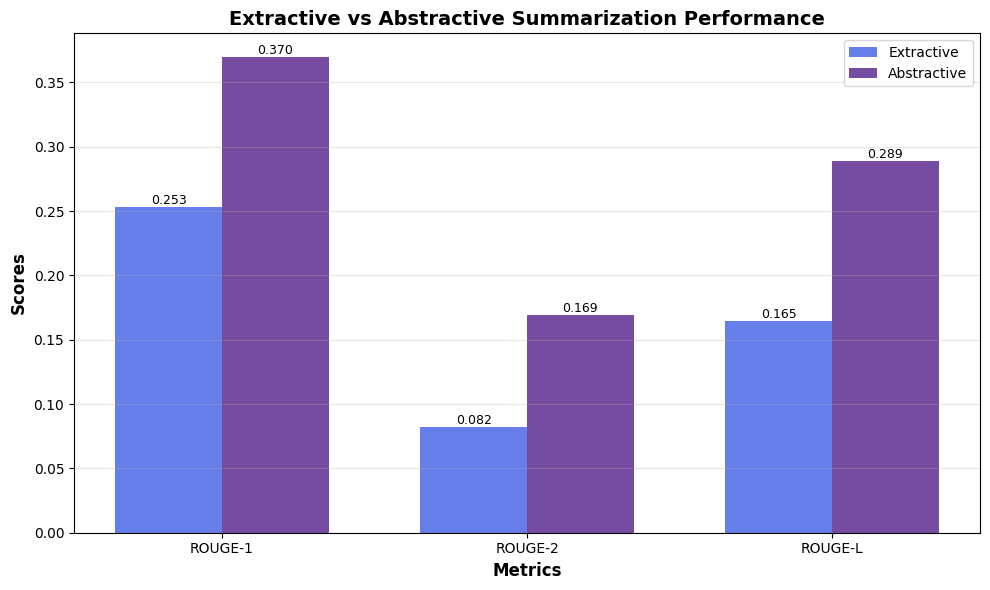

In [22]:
import matplotlib.pyplot as plt

# Prepare data for visualization
metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
extractive_scores = [
    np.mean(results['extractive']['rouge1']),
    np.mean(results['extractive']['rouge2']),
    np.mean(results['extractive']['rougeL'])
]
abstractive_scores = [
    np.mean(results['abstractive']['rouge1']),
    np.mean(results['abstractive']['rouge2']),
    np.mean(results['abstractive']['rougeL'])
]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, extractive_scores, width, label='Extractive', color='#667eea')
bars2 = ax.bar(x + width/2, abstractive_scores, width, label='Abstractive', color='#764ba2')

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Scores', fontsize=12, fontweight='bold')
ax.set_title('Extractive vs Abstractive Summarization Performance', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 13. Create Results DataFrame

In [23]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Method': ['Extractive (TextRank)', 'Abstractive (BART)'],
    'ROUGE-1': [np.mean(results['extractive']['rouge1']), 
                np.mean(results['abstractive']['rouge1'])],
    'ROUGE-2': [np.mean(results['extractive']['rouge2']), 
                np.mean(results['abstractive']['rouge2'])],
    'ROUGE-L': [np.mean(results['extractive']['rougeL']), 
                np.mean(results['abstractive']['rougeL'])]
})

print("\nComparison Summary:")
print("="*60)
print(comparison_df.to_string(index=False))
print("="*60)


Comparison Summary:
               Method  ROUGE-1  ROUGE-2  ROUGE-L
Extractive (TextRank) 0.253483 0.082368 0.164737
   Abstractive (BART) 0.369680 0.169494 0.288969


## 14. Save Models for Web Application

In [24]:
import pickle

print("Saving models for web application...\n")

# Save extractive model
with open('extractive_model.pkl', 'wb') as f:
    pickle.dump(extractive_model, f)

print("✓ Extractive model saved as 'extractive_model.pkl'")
print("✓ Abstractive model will be loaded directly in web app")
print("\n🎉 All done! Models ready for deployment!")

Saving models for web application...

✓ Extractive model saved as 'extractive_model.pkl'
✓ Abstractive model will be loaded directly in web app

🎉 All done! Models ready for deployment!


## 15. Test with Custom Business Text

In [25]:
# Test with your own business text
custom_text = """
Tesla Inc. reported record quarterly revenue on Wednesday, beating Wall Street expectations 
as the electric vehicle maker delivered more cars than anticipated. The company's revenue 
reached $25.2 billion in the fourth quarter, up 37% from a year earlier. Net income rose 
to $3.7 billion. CEO Elon Musk said the company expects to produce 2 million vehicles in 2024, 
doubling its current production capacity. The strong results come despite concerns about 
increasing competition in the EV market and economic headwinds. Tesla's stock price jumped 
8% in after-hours trading following the announcement.
"""

print("Testing with custom business text:\n")
print("Original Text:")
print("="*60)
print(custom_text.strip())
print("\n" + "="*60)

print("\nExtractive Summary:")
print("-"*60)
print(extractive_model.summarize(custom_text, num_sentences=2))

print("\n" + "="*60)
print("\nAbstractive Summary:")
print("-"*60)
print(abstractive_model.summarize(custom_text, max_length=100, min_length=30))

Testing with custom business text:

Original Text:
Tesla Inc. reported record quarterly revenue on Wednesday, beating Wall Street expectations 
as the electric vehicle maker delivered more cars than anticipated. The company's revenue 
reached $25.2 billion in the fourth quarter, up 37% from a year earlier. Net income rose 
to $3.7 billion. CEO Elon Musk said the company expects to produce 2 million vehicles in 2024, 
doubling its current production capacity. The strong results come despite concerns about 
increasing competition in the EV market and economic headwinds. Tesla's stock price jumped 
8% in after-hours trading following the announcement.


Extractive Summary:
------------------------------------------------------------
The company's revenue 
reached $25.2 billion in the fourth quarter, up 37% from a year earlier. The strong results come despite concerns about 
increasing competition in the EV market and economic headwinds.


Abstractive Summary:
-----------------------------

## 🎯 Project Complete!

### What We Built:
1. ✅ Extractive Summarization (TextRank Algorithm)
2. ✅ Abstractive Summarization (BART Model)
3. ✅ Evaluation on CNN/DailyMail Dataset
4. ✅ ROUGE Score Comparison
5. ✅ Models Saved for Web Application

### Next Steps:
- Run `python app.py` to start the web application
- Visit http://localhost:5000 in your browser
- Test both summarization methods on business documents!
